In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [17]:
# Directory where the Excel files are stored
base_path = "/Users/tinazhang/Downloads/"

# national data
years = list(range(2001, 2024))  # From 2001 to 2023
national_data = {}

# Loop through each year and read the corresponding Excel file
for year in years:
    file_name = f"national_M{year}_dl.csv"  # Construct the file name
    file_path = base_path + file_name  # Construct the full file path

    # Read the Excel file into a DataFrame
    df = pd.read_csv(file_path)
    try:
        data_filtered = df[['OCC_CODE', 'TOT_EMP', 'A_MEAN', 'A_MEDIAN']]
    except: # if lowercase
        data_filtered = df[['occ_code', 'tot_emp', 'a_mean', 'a_median']]

    # Rename columns
    data_filtered.columns = ["OCC_CODE", "TOT_EMP", "A_MEAN", "A_MEDIAN"]

    national_data[year] = data_filtered


In [18]:
# map 2010 SOC codes to 2018 SOC codes
crosswalk1 = pd.read_excel("/Users/tinazhang/Downloads/soc_2010_to_2018_crosswalk.xlsx")
soc_mapping1 = dict(zip(crosswalk1['U.S. Bureau of Labor Statistics'], crosswalk1['Unnamed: 2']))

In [19]:
# map 2000 SOC codes to 2010 SOC codes
crosswalk2 = pd.read_excel("/Users/tinazhang/Downloads/soc_2000_to_2010_crosswalk.xlsx")
soc_mapping2 = dict(zip(crosswalk2['Bureau of Labor Statistics'], crosswalk2['Unnamed: 2']))

In [20]:
# Remove all columns except OCC_CODE, A_MEAN, A_MEDIAN, TOT_EMP
for year, data in national_data.items():
    data_copy = data.copy()
    
    data_copy["TOT_EMP"]=data_copy["TOT_EMP"].astype(str).str.replace(",", "")
    data_copy["TOT_EMP"]=data_copy["TOT_EMP"].str.replace("*", "")
    data_copy["A_MEAN"]=data_copy["A_MEAN"].astype(str).str.replace(",", "")
    data_copy["A_MEAN"]=data_copy["A_MEAN"].str.replace("*", "")
    data_copy["A_MEDIAN"]=data_copy["A_MEDIAN"].astype(str).str.replace(",", "")
    data_copy["A_MEDIAN"]=data_copy["A_MEDIAN"].str.replace("*", "")

    data_copy["TOT_EMP"]=pd.to_numeric(data_copy["TOT_EMP"], errors="coerce").astype(float)
    data_copy["A_MEAN"]=pd.to_numeric(data_copy["A_MEAN"], errors="coerce").astype(float)
    data_copy["A_MEDIAN"]=pd.to_numeric(data_copy["A_MEDIAN"], errors="coerce").astype(float)
    data_copy["YEAR"] = year
    
    data_copy.rename(columns = {"OCC_CODE": "original_soc"}, inplace=True)
    data_copy['2018_soc'] = data_copy["original_soc"].map(soc_mapping1)
    data_copy['2010_soc'] = data_copy["original_soc"].map(soc_mapping2)
    
    national_data[year] = data_copy

In [21]:
# Check occupations with missing years (YEAR column)
# If so, fill in with linear interpolation

for year, data in national_data.items():
    # check for missing years
    missing_years = data[data['YEAR'].isna()]
    
    # linear interpolation to fill missing values in 'YEAR' col
    data['YEAR'] = data['YEAR'].interpolate(method='linear', limit_direction='both')
    
    # update dictionary with updated dataframe
    national_data[year] = data

In [22]:
# check if any occupations have missing wages/employment data
missing_ndata = {}

for year, data in national_data.items():
    # check for missing values in TOT_EMP, A_MEAN, and A_MEDIAN
    missing_tot_emp = data['TOT_EMP'].isna().sum()
    missing_a_mean = data['A_MEAN'].isna().sum()
    missing_a_median = data['A_MEDIAN'].isna().sum()
    
    # store missing data counts in a dictionary for current year
    missing_ndata[year] = {
        'Missing TOT_EMP': missing_tot_emp,
        'Missing A_MEAN': missing_a_mean,
        'Missing A_MEDIAN': missing_a_median
    }

print(missing_ndata)

{2001: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 2, 'Missing A_MEDIAN': 6}, 2002: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 2, 'Missing A_MEDIAN': 6}, 2003: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 2, 'Missing A_MEDIAN': 6}, 2004: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 6, 'Missing A_MEDIAN': 14}, 2005: {'Missing TOT_EMP': 2, 'Missing A_MEAN': 6, 'Missing A_MEDIAN': 14}, 2006: {'Missing TOT_EMP': 1, 'Missing A_MEAN': 6, 'Missing A_MEDIAN': 17}, 2007: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 4, 'Missing A_MEDIAN': 15}, 2008: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 4, 'Missing A_MEDIAN': 12}, 2009: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 4, 'Missing A_MEDIAN': 11}, 2010: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 4, 'Missing A_MEDIAN': 11}, 2011: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 4, 'Missing A_MEDIAN': 10}, 2012: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 6, 'Missing A_MEDIAN': 14}, 2013: {'Missing TOT_EMP': 0, 'Missing A_MEAN': 6, 'Missing A_MEDIAN': 13}, 2014: {'Missing TOT_EMP': 0

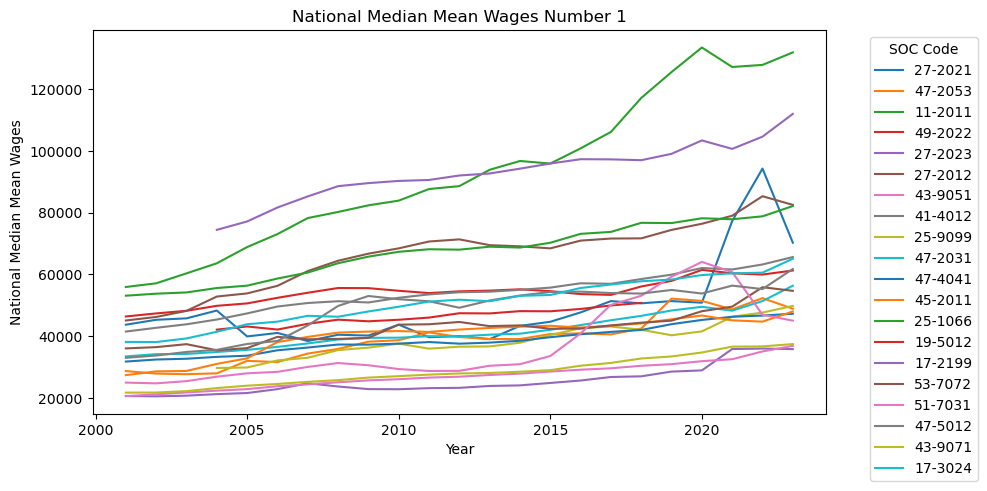

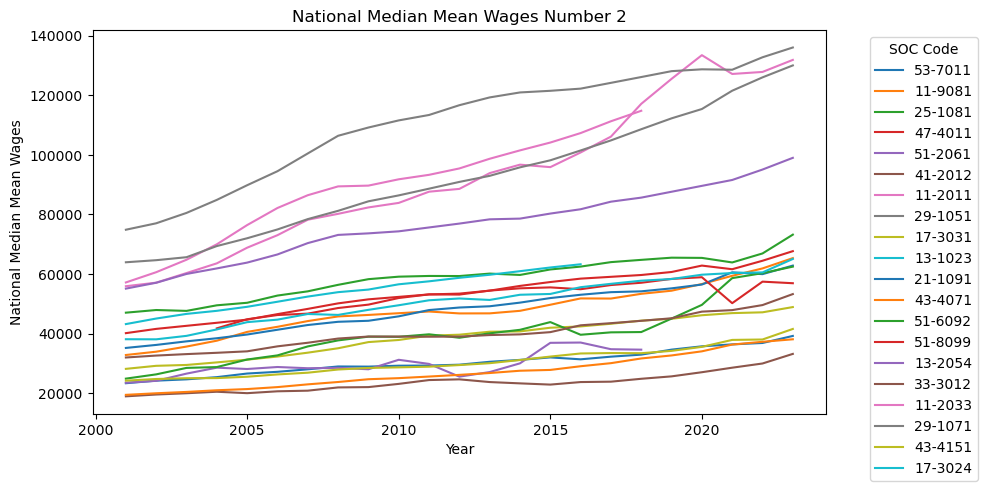

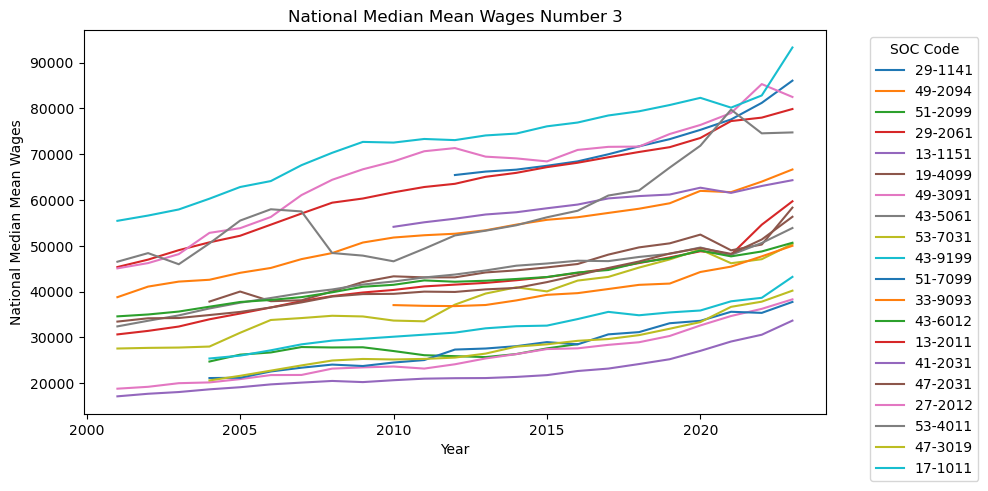

In [23]:
# concatenate data from all years into a ONE df
all_data = pd.concat(national_data.values())
all_data.to_csv('/Users/tinazhang/Downloads/national_data.csv', index=False)
num_samples=3
sample_size = 20
unique_occupations = all_data['2018_soc'].dropna().unique()

# plot the data for each set of 20 occupations
for sample_num in range(1, num_samples + 1):
    random_occupations = random.sample(list(unique_occupations), sample_size)
    
    filtered_data = all_data[all_data['2018_soc'].isin(random_occupations)]
    
    # plot
    plt.figure(figsize=(10, 5))
    for occupation in random_occupations:
        occupation_data = filtered_data[filtered_data['2018_soc'] == occupation]
        plt.plot(occupation_data['YEAR'], occupation_data['A_MEDIAN'], label=occupation)

    
    plt.title(f'National Median Mean Wages Number {sample_num}')
    plt.xlabel('Year')
    plt.ylabel('National Median Mean Wages')
    plt.legend(title="SOC Code", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [24]:
# SOURCE: https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/

# check if wages are deflated or not
# consumer price index from 2010 to 2023
cpi_vals = [218.056, 224.939, 229.594, 232.957, 236.736, 237.017, 240.007, 245.120, 251.107, 255.657, 258.811,270.970, 292.797, 306.746]

cpi_data = {(2010+i): cpi_vals[i] for i, val in enumerate(cpi_vals)}

# create df from cpi data
cpi_df = pd.DataFrame(list(cpi_data.items()), columns=['YEAR', 'CPI'])
cpi_df

# merge CPI data with wages data
all_data_with_cpi = pd.merge(all_data, cpi_df, on='YEAR', how='left')

base_year_cpi = cpi_df[cpi_df['YEAR'] == 2010]['CPI'].values[0]

# adjust wages for inflation by multiplying by the base year CPI and dividing by the year-specific CPI
all_data_with_cpi['real_A_MEAN'] = all_data_with_cpi['A_MEAN'] * (base_year_cpi / all_data_with_cpi['CPI'])
all_data_with_cpi

,original_soc,TOT_EMP,A_MEAN,A_MEDIAN,YEAR,2018_soc,2010_soc,CPI,real_A_MEAN
0,00-0000,127980410.0,34020.0,27060.0,2001,NaN,NaN,NaN,NaN
1,11-0000,7212360.0,70800.0,64220.0,2001,NaN,NaN,NaN,NaN
2,11-1011,455930.0,107670.0,120450.0,2001,11-1011,11-1011,NaN,NaN
3,11-1021,2064220.0,73570.0,65000.0,2001,11-1021,11-1021,NaN,NaN
4,11-1031,67400.0,28170.0,14650.0,2001,11-1031,11-1031,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25367,53-7081,135430.0,47810.0,45760.0,2023,53-7081,53-7081,306.746,33986.612246
25368,53-7120,11400.0,60530.0,58620.0,2023,NaN,NaN,306.746,43028.856709
25369,53-7121,11400.0,60530.0,58620.0,2023,53-7121,53-7121,306.746,43028.856709
25370,53-7190,23970.0,45840.0,40310.0,2023,NaN,NaN,306.746,32586.201743
